In [1]:
import pymongo
import re
import pandas as pd
import matplotlib.pyplot as plt
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, to_date

In [ ]:
# Connecting to MongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017")

# Creating Spark session
spark = SparkSession.builder.appName('EconComparison').getOrCreate()

# Creating VADER
analyzer = SentimentIntensityAnalyzer()

## Processing Popular Tweet Sentiments (Monthly)

In [3]:
"""
queries all the tweets for a given database and collection
"""
def find_all_tweets(db_client, db_name, coll_name):
    db = db_client[db_name]
    collection = db[coll_name]
    # Defining and executing a query to obtain an aggregated list of tweets per year 
    pipeline = [{'$project': {
            'tweet': 1,
            'year': {
                '$year': {'$dateFromString': {'dateString': '$date'}},
            },
            'month': {
                '$month': {'$dateFromString': {'dateString': '$date'}},
            },
    }},
    {'$group': {
            '_id': {
                'year': '$year',
                'month': '$month'
            },
            'tweets': {'$push': '$tweet'},
            'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}]
    
    results = list(collection.aggregate(pipeline))
    
    return results 

In [4]:
popular_tweets_monthly = find_all_tweets(client, "ds4300", "popular_tweets")

In [5]:
"""
clean/process the queried db tweets
"""
def process_tweets(results):
    for result in results: 
        tweets = result['tweets'] 
        processed_tweets = []
        for tweet in tweets: 
            s = tweet.lower()
            s = s.translate(str.maketrans("", "", string.punctuation))
            s = re.sub(r'\d+', '', s)
            
            # Append the processed string to the output list
            processed_tweets.append(s)
    # Replace the original tweets with the processed tweets
    result['tweets'] = processed_tweets
    
    return results

In [6]:
processed_pop_monthly_tweets = process_tweets(popular_tweets_monthly)

In [7]:
"""
conduct sentiment analysis on tweets 
"""
def analyze_sentiment(results):
    # defining an empty dictionary 
    month_sentiment = {}
    
    for result in results:
        # define year and list of tweets
        year = result['_id']['year']
        month = result['_id']['month']
        date = datetime.date(year, month, 1)
        tweets = result['tweets']

        # use VADER to keep track of avg compound scores for a given year 
        sentiment_scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in tweets] 
        month_sentiment[date] = (sum(sentiment_scores)/len(sentiment_scores)) * 100
        
    # Create a DataFrame from the dictionary
    monthly_df = pd.DataFrame(list(month_sentiment.items()), columns=['Date', 'Score'])

    return monthly_df

In [8]:
pop_sentiment_monthly = analyze_sentiment(processed_pop_monthly_tweets)

In [9]:
def calc_sentiment(results):
    sentiment_list = []

    i = 1
    for result in results:
        # define date and list of tweets
        year = result['_id']['year']
        month = result['_id']['month']
        date = datetime.date(year, month, 1)
        tweets = result['tweets'] 
        tweet_text = ' '.join(tweets)
        
        scores = analyzer.polarity_scores(tweet_text)
        
        # Extract the negative, positive, and neutral scores from the dictionary
        negative_score = scores["neg"]
        positive_score = scores["pos"]
        neutral_score = scores["neu"]
        
        # Calculate the percentage of negative, positive, and neutral sentiment in the text
        total_score = negative_score + positive_score + neutral_score
        negative_percentage = (negative_score / total_score) * 100
        positive_percentage = (positive_score / total_score) * 100
        
        # Create a dictionary with the year, positive and negative percentage
        sentiment_dict = {
            'date': date,
            'negative_percentage': - negative_percentage,
            'positive_percentage': positive_percentage,
            'score': (positive_score - negative_score) * 100}
        sentiment_list.append(sentiment_dict)
        print(i)
        i += 1
        
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(sentiment_list)
    
    return df

In [10]:
pop_sentiment_monthly

,Date,Score
0,2011-02-01,86.250000
1,2012-06-01,21.680000
2,2012-10-01,0.000000
3,2012-11-01,20.880000
4,2013-02-01,65.423333
...,...,...
103,2022-07-01,1.981167
104,2022-08-01,23.522000
105,2022-09-01,13.828000
106,2022-10-01,40.953667


In [ ]:
pop_sentiment_monthly_percent = calc_sentiment(processed_pop_monthly_tweets)

In [12]:
pop_sentiment_monthly_percent

,date,negative_percentage,positive_percentage,score
0,2011-02-01,-0.000000,42.00000,42.0
1,2012-06-01,-19.200000,26.40000,7.2
2,2012-10-01,-9.900000,9.90000,0.0
3,2012-11-01,-9.000000,15.60000,6.6
4,2013-02-01,-0.000000,26.70000,26.7
...,...,...,...,...
103,2022-07-01,-13.800000,16.90000,3.1
104,2022-08-01,-9.200000,14.00000,4.8
105,2022-09-01,-11.900000,17.40000,5.5
106,2022-10-01,-7.000000,18.60000,11.6


In [13]:
def sentiment_analysis_rate_change_plot(df, title):
    fig, ax1 = plt.subplots(figsize=(30, 15))

    # dates as x-values (excluding 1st date bc cannot calc rate of change)
    x = df['date'][1:]
    # calculate percent change for y-values
    score = np.array(df['score'])
    y = (score[1:] - score[:-1]) / score[:-1]

    # Create lineplot with sentiment score percent change vs month
    ax1.plot(x, y, color='black', linewidth=2, label='Sentiment Score % Change')

    # # Set labels and titles
    ax1.set_xlabel('Date')
    ax1.set_ylabel('% Change')
    ax1.set_title(title)

    ax1.legend()
    # Show the plot
    plt.show()

/var/folders/ph/gzj9kkyd6c3155gzpj4kgw840000gn/T/ipykernel_18767/574512047.py:8: RuntimeWarning: divide by zero encountered in divide
  y = (score[1:] - score[:-1]) / score[:-1]


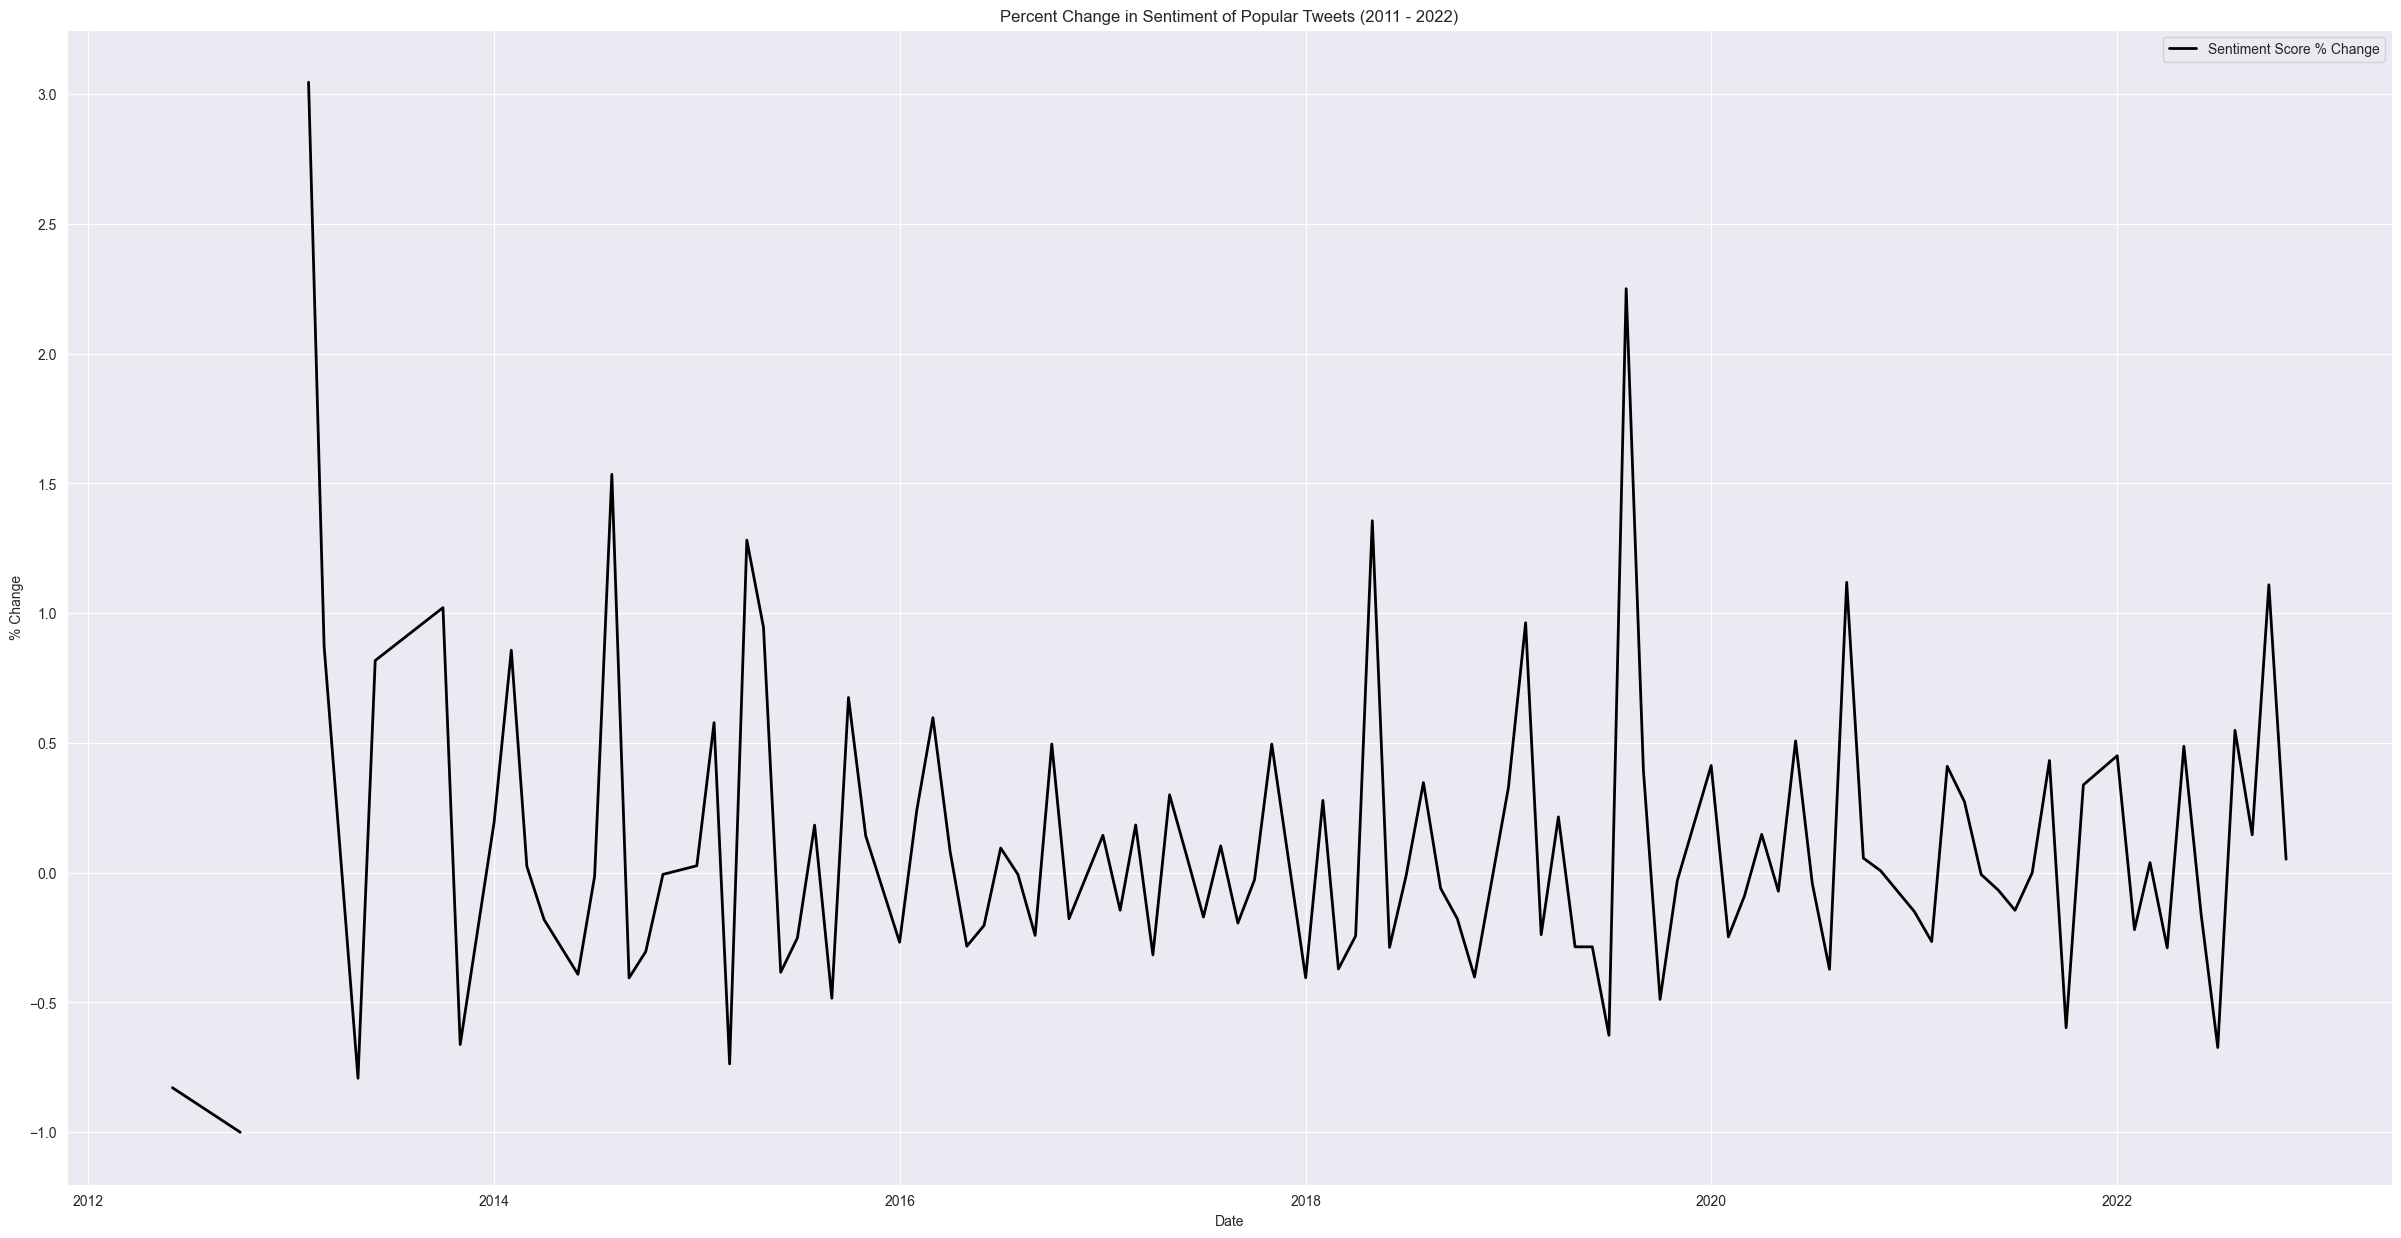

In [14]:
sentiment_analysis_rate_change_plot(pop_sentiment_monthly_percent, "Percent Change in Sentiment of Popular Tweets (2011 - 2022)")

## Processing Stock Indexes (Monthly)

In [15]:
def clean_stock_data(csv_name):
    # read CSV into pyspark
    df = spark.read.format('csv')\
        .option('header', 'true').option('inferSchema', 'false').load(csv_name)

    # clean data and apply correct column types
    df = df.withColumn('Date', to_date(df['Date'], 'd-MMM-yy'))\
        .withColumn('Open', regexp_replace('Open', ',', '').cast('float'))\
        .withColumn('High', regexp_replace('High', ',', '').cast('float'))\
        .withColumn('Low', regexp_replace('Low', ',', '').cast('float'))\
        .withColumn('Close*', regexp_replace('Close*', ',', '').cast('float'))\
        .withColumn('Adj Close**', regexp_replace('Adj Close**', ',', '').cast('float'))\
        .withColumn('Volume', regexp_replace('Volume', ',', '').cast('float'))

    # sort by date ascending
    df = df.sort("Date")

    return df

In [17]:
# Dow Jones Industrial Average
dow_jones = clean_stock_data('dow_jones.csv')
dow_jones.show()

+----------+--------+--------+--------+--------+-----------+------------+
|      Date|    Open|    High|     Low|  Close*|Adj Close**|      Volume|
+----------+--------+--------+--------+--------+-----------+------------+
|2007-01-01|12459.54|12657.02|12337.37|12621.69|   12621.69| 5.0754401E9|
|2007-02-01| 12617.2|12795.93|12086.06|12268.63|   12268.63| 4.3474202E9|
|2007-03-01|12268.63|12511.05|11939.61|12354.35|   12354.35| 5.6331802E9|
|2007-04-01|12354.52|13162.06|12324.28|13062.91|   13062.91| 4.8198098E9|
|2007-05-01|13062.75|13673.07| 13041.3|13627.64|   13627.64|   5.03985E9|
|2007-06-01|13628.69| 13692.0|13251.53|13408.62|   13408.62| 5.2276198E9|
|2007-07-01| 13409.6|14021.95|13199.79|13211.99|   13211.99| 5.5120399E9|
|2007-08-01|13211.09|13695.82|12517.94|13357.74|   13357.74| 6.1991199E9|
|2007-09-01|13358.39|13924.81|13021.93|13895.63|   13895.63| 4.3283702E9|
|2007-10-01|13895.71| 14198.1|13407.49|13930.01|   13930.01| 5.0109199E9|
|2007-11-01|13924.16|13924.16|12724.09

In [18]:
# S&P 500
sp500 = clean_stock_data('sp500.csv')
sp500.show()

+----------+-------+-------+-------+-------+-----------+-------------+
|      Date|   Open|   High|    Low| Close*|Adj Close**|       Volume|
+----------+-------+-------+-------+-------+-----------+-------------+
|2007-01-01|1418.03|1441.61|1403.97|1438.24|    1438.24| 5.6686199E10|
|2007-02-01| 1437.9|1461.57|1389.42|1406.82|    1406.82| 5.1844989E10|
|2007-03-01| 1406.8|1438.89|1363.98|1420.86|    1420.86| 6.7622248E10|
|2007-04-01|1420.83|1498.02|1416.37|1482.37|    1482.37| 5.7032471E10|
|2007-05-01|1482.37|1535.56| 1476.7|1530.62|    1530.62|  6.495805E10|
|2007-06-01|1530.62|1540.56|1484.18|1503.35|    1503.35| 6.5322799E10|
|2007-07-01|1504.66| 1555.9|1454.25|1455.27|    1455.27|  7.033743E10|
|2007-08-01|1455.18|1503.89| 1370.6|1473.99|    1473.99|  9.138176E10|
|2007-09-01|1473.96|1538.74|1439.29|1526.75|    1526.75| 5.7809699E10|
|2007-10-01|1527.29|1576.09|1489.56|1549.38|    1549.38| 7.6022579E10|
|2007-11-01|1545.79|1545.79| 1406.1|1481.14|    1481.14| 8.6246949E10|
|2007-

In [19]:
# NASDAQ Composite
nasdaq = clean_stock_data('nasdaq-comp.csv')
nasdaq.show()

+----------+-------+-------+-------+-------+-----------+------------+
|      Date|   Open|   High|    Low| Close*|Adj Close**|      Volume|
+----------+-------+-------+-------+-------+-----------+------------+
|2007-01-01|2429.72|2508.93|2394.66|2463.93|    2463.93|4.2688492E10|
|2007-02-01|2474.08|2531.42|2395.35|2416.15|    2416.15|3.9700562E10|
|2007-03-01|2377.18|2459.96|2331.57|2421.64|    2421.64|4.3563901E10|
|2007-04-01|2425.36|2562.99|2409.04|2525.09|    2525.09|3.9716999E10|
|2007-05-01|2529.95| 2607.9|2510.57|2604.52|    2604.52|4.4252459E10|
|2007-06-01|2614.01| 2634.6|2534.97|2603.23|    2603.23|4.5340312E10|
|2007-07-01|2617.39|2724.74| 2545.9|2546.27|    2546.27| 4.510736E10|
|2007-08-01| 2538.5|2627.75|2386.69|2596.36|    2596.36|5.2126032E10|
|2007-09-01|2596.38|2716.75|2536.93| 2701.5|     2701.5| 3.525725E10|
|2007-10-01|2704.25|2861.51|2698.14|2859.12|    2859.12| 4.875162E10|
|2007-11-01| 2835.0|2835.63|2539.81|2660.96|    2660.96|5.0214789E10|
|2007-12-01|2654.91|

In [24]:
def plot_stock_rate_change(df, title, y_label):
    fig, ax1 = plt.subplots(figsize=(30, 15))

    # dates as x-values (excluding 1st date bc cannot calc rate of change)
    x = np.array(df.select('Date').collect()).reshape(-1)[1:]
    # calculate percent change for y-values
    index = np.array(df.select('Open').collect()).reshape(-1)
    y = (index[1:] - index[:-1]) / index[:-1]

    # Create lineplot with sentiment score percent change vs month
    ax1.plot(x, y, color='black', linewidth=2, label=y_label)

    # # Set labels and titles
    ax1.set_xlabel('Date')
    ax1.set_ylabel('% Change')
    ax1.set_title(title)

    ax1.legend()
    # Show the plot
    plt.show()

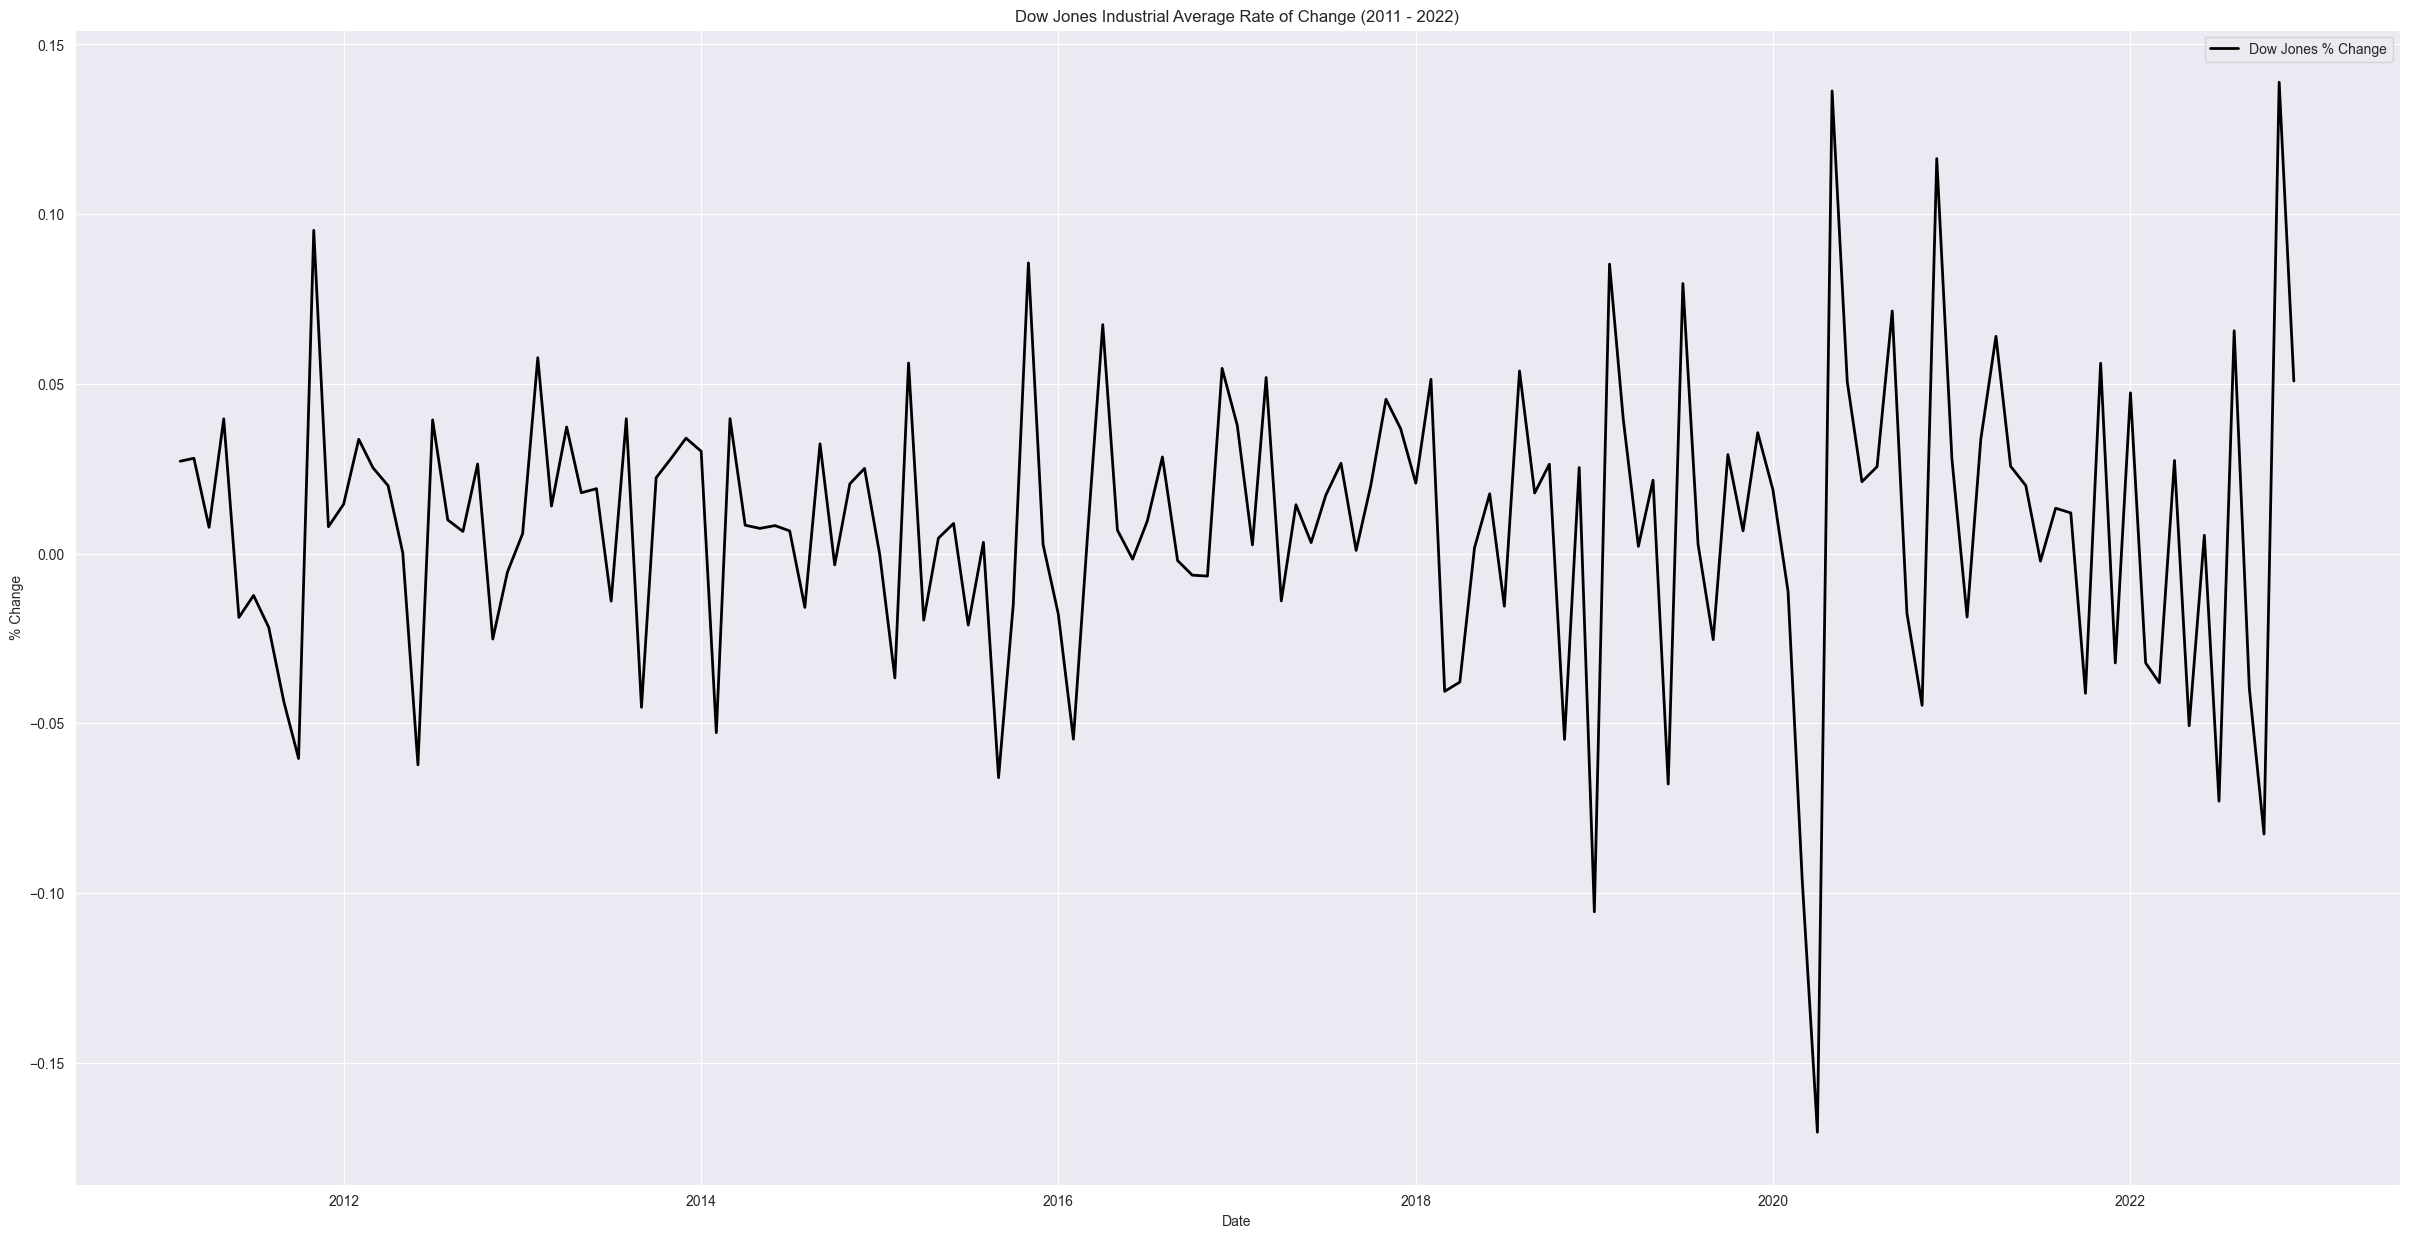

In [27]:
dow_jones_2011_2022 = dow_jones.where(dow_jones.Date > datetime.date(2010, 12, 31)).where(dow_jones.Date < datetime.date(2023, 1, 1))
plot_stock_rate_change(dow_jones_2011_2022, "Dow Jones Industrial Average Rate of Change (2011 - 2022)", "Dow Jones % Change")

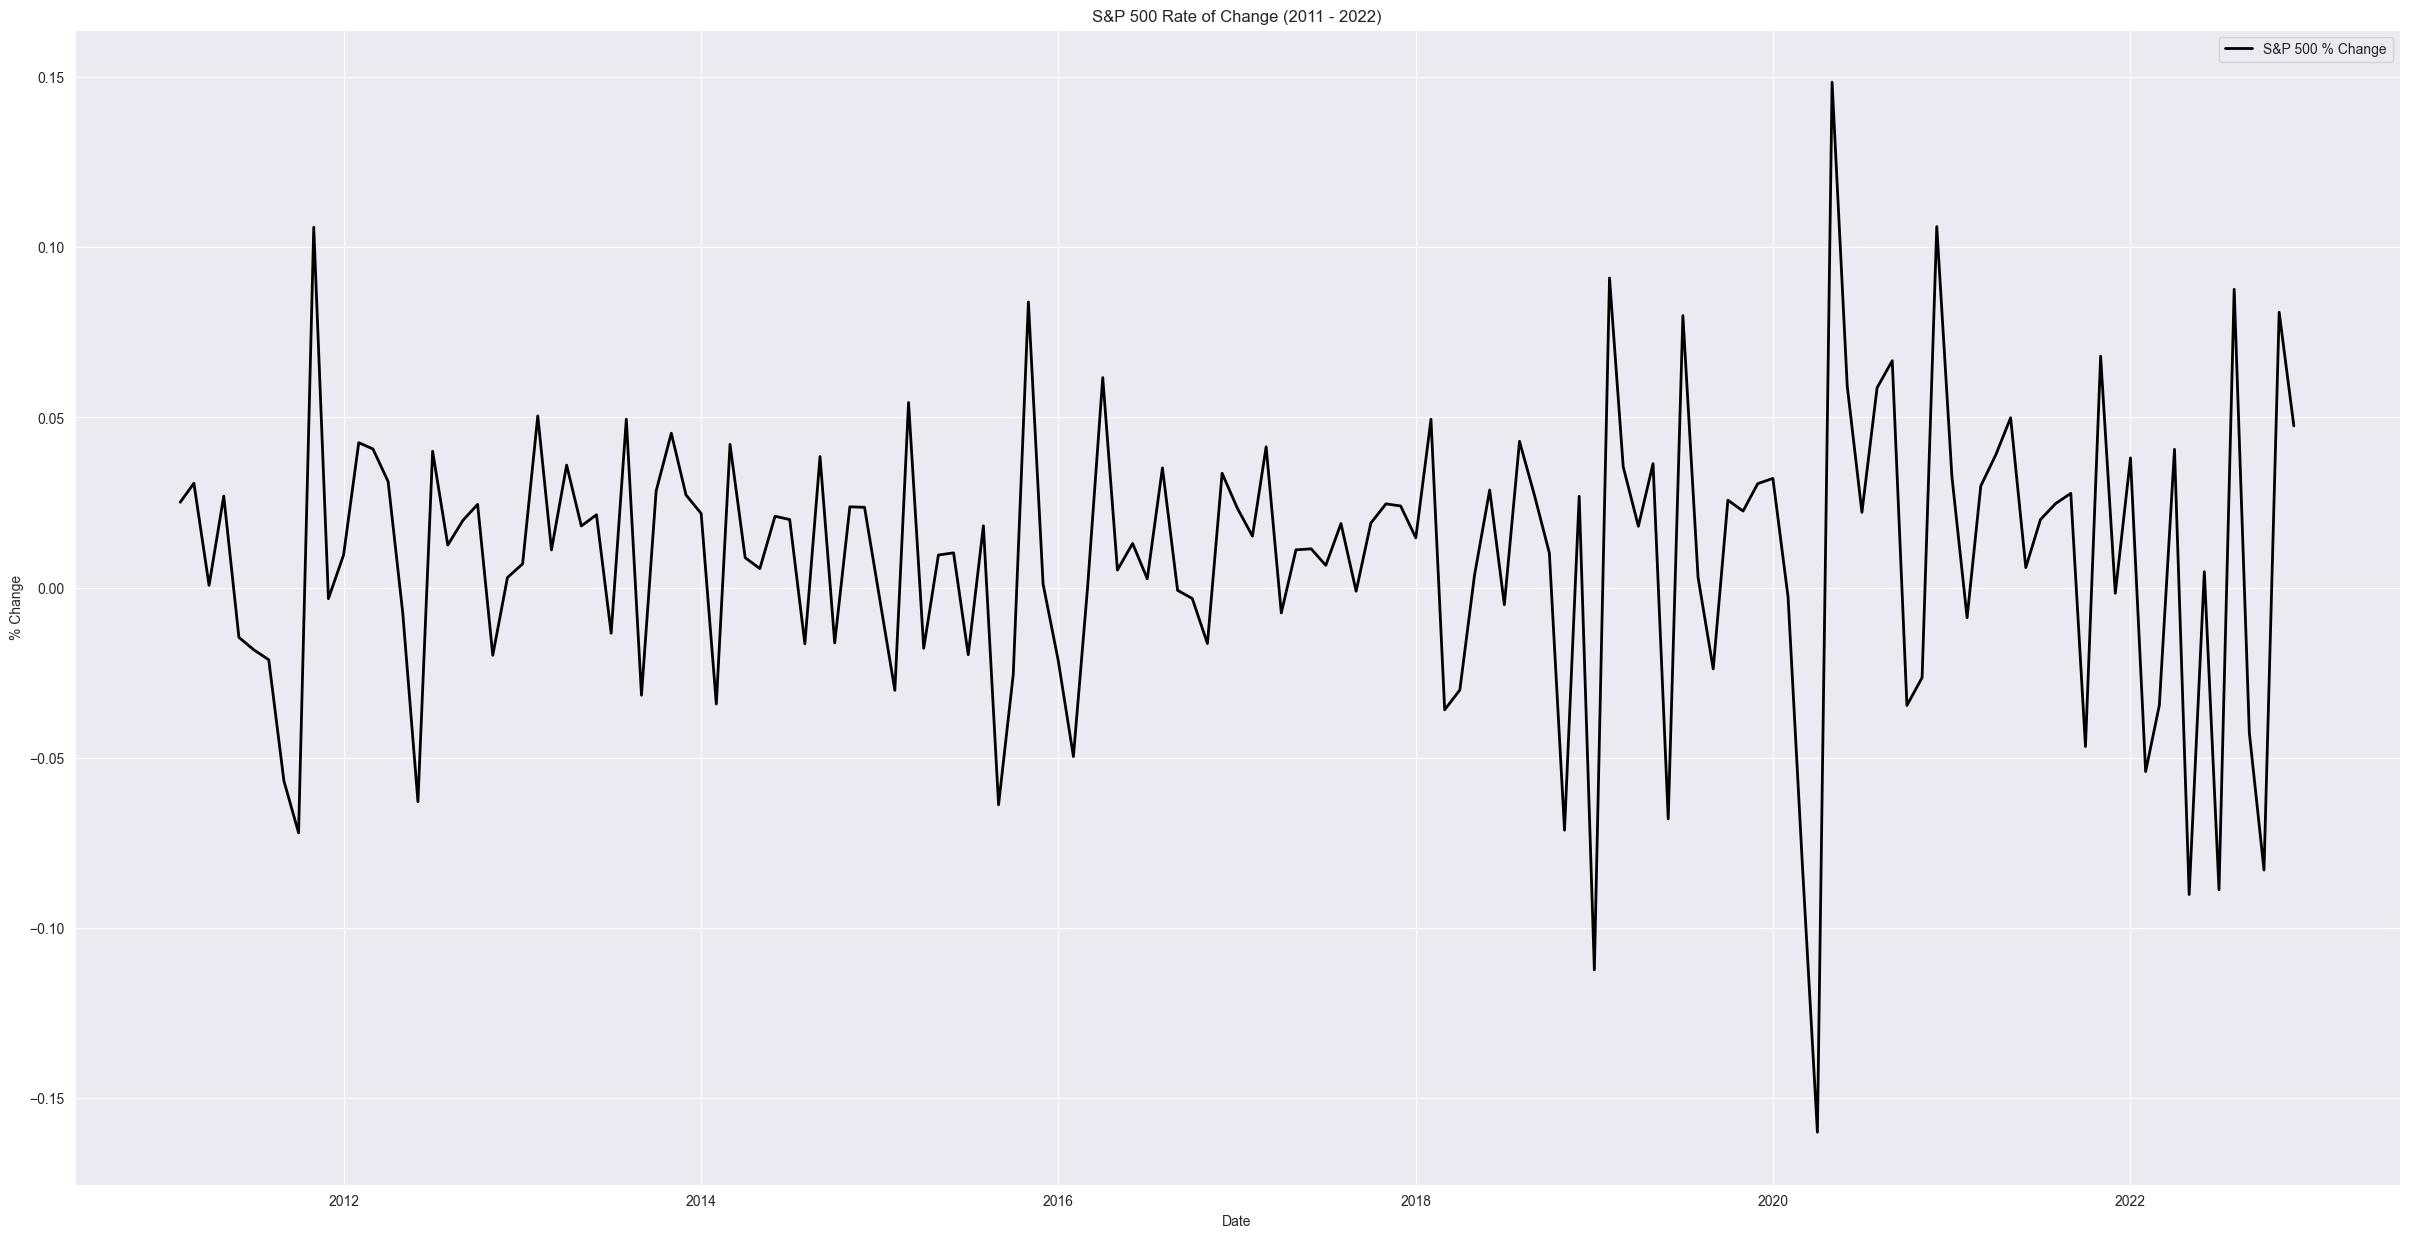

In [28]:
sp500_2011_2022 = sp500.where(sp500.Date > datetime.date(2010, 12, 31)).where(sp500.Date < datetime.date(2023, 1, 1))
plot_stock_rate_change(sp500_2011_2022, "S&P 500 Rate of Change (2011 - 2022)", "S&P 500 % Change")

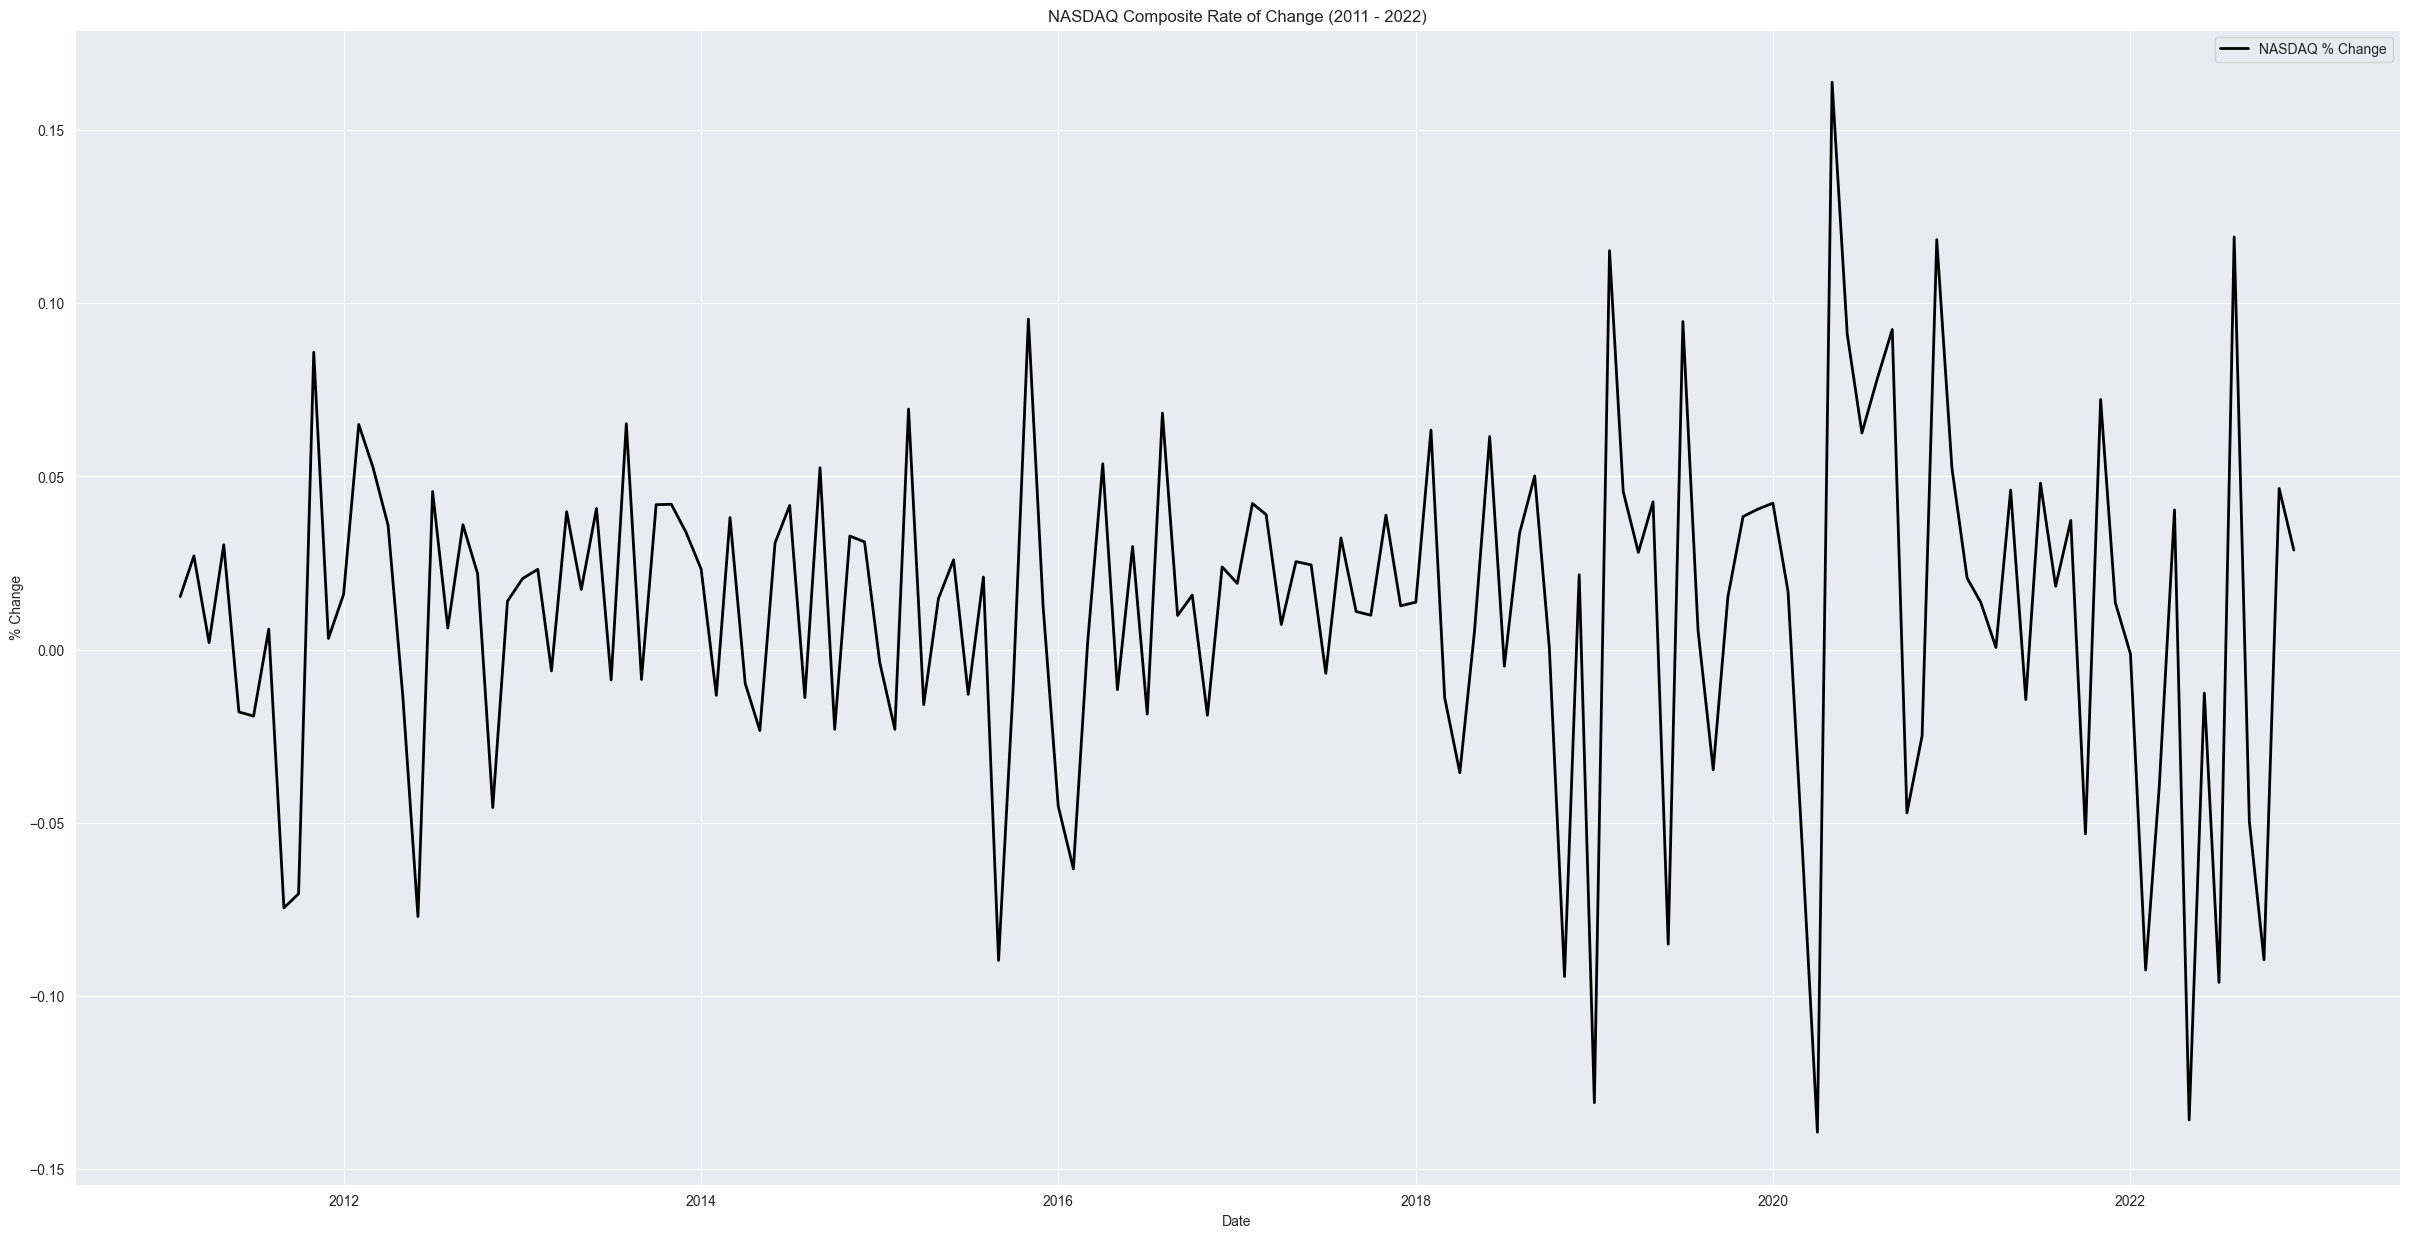

In [29]:
nasdaq_2011_2022 = nasdaq.where(nasdaq.Date > datetime.date(2010, 12, 31)).where(nasdaq.Date < datetime.date(2023, 1, 1))
plot_stock_rate_change(nasdaq_2011_2022, "NASDAQ Composite Rate of Change (2011 - 2022)", "NASDAQ % Change")

In [37]:
def plot_all_stock_rate_change(dfs, title, y_labels, colors):
    fig, ax = plt.subplots(figsize=(30, 15))

    for i in range(len(dfs)):
        df = dfs[i]
        y_label = y_labels[i]
        color = colors[i]
        ax1 = ax.twinx()

        # dates as x-values (excluding 1st date bc cannot calc rate of change)
        x = np.array(df.select('Date').collect()).reshape(-1)[1:]
        # calculate percent change for y-values
        index = np.array(df.select('Open').collect()).reshape(-1)
        y = (index[1:] - index[:-1]) / index[:-1]

        # Create lineplot with sentiment score percent change vs month
        ax1.plot(x, y, color=color, linewidth=2, label=y_label)
        ax1.legend()

    # # Set labels and titles
    ax.set_xlabel('Date')
    ax.set_ylabel('% Change')
    ax.set_title(title)

    # Show the plot
    plt.show()

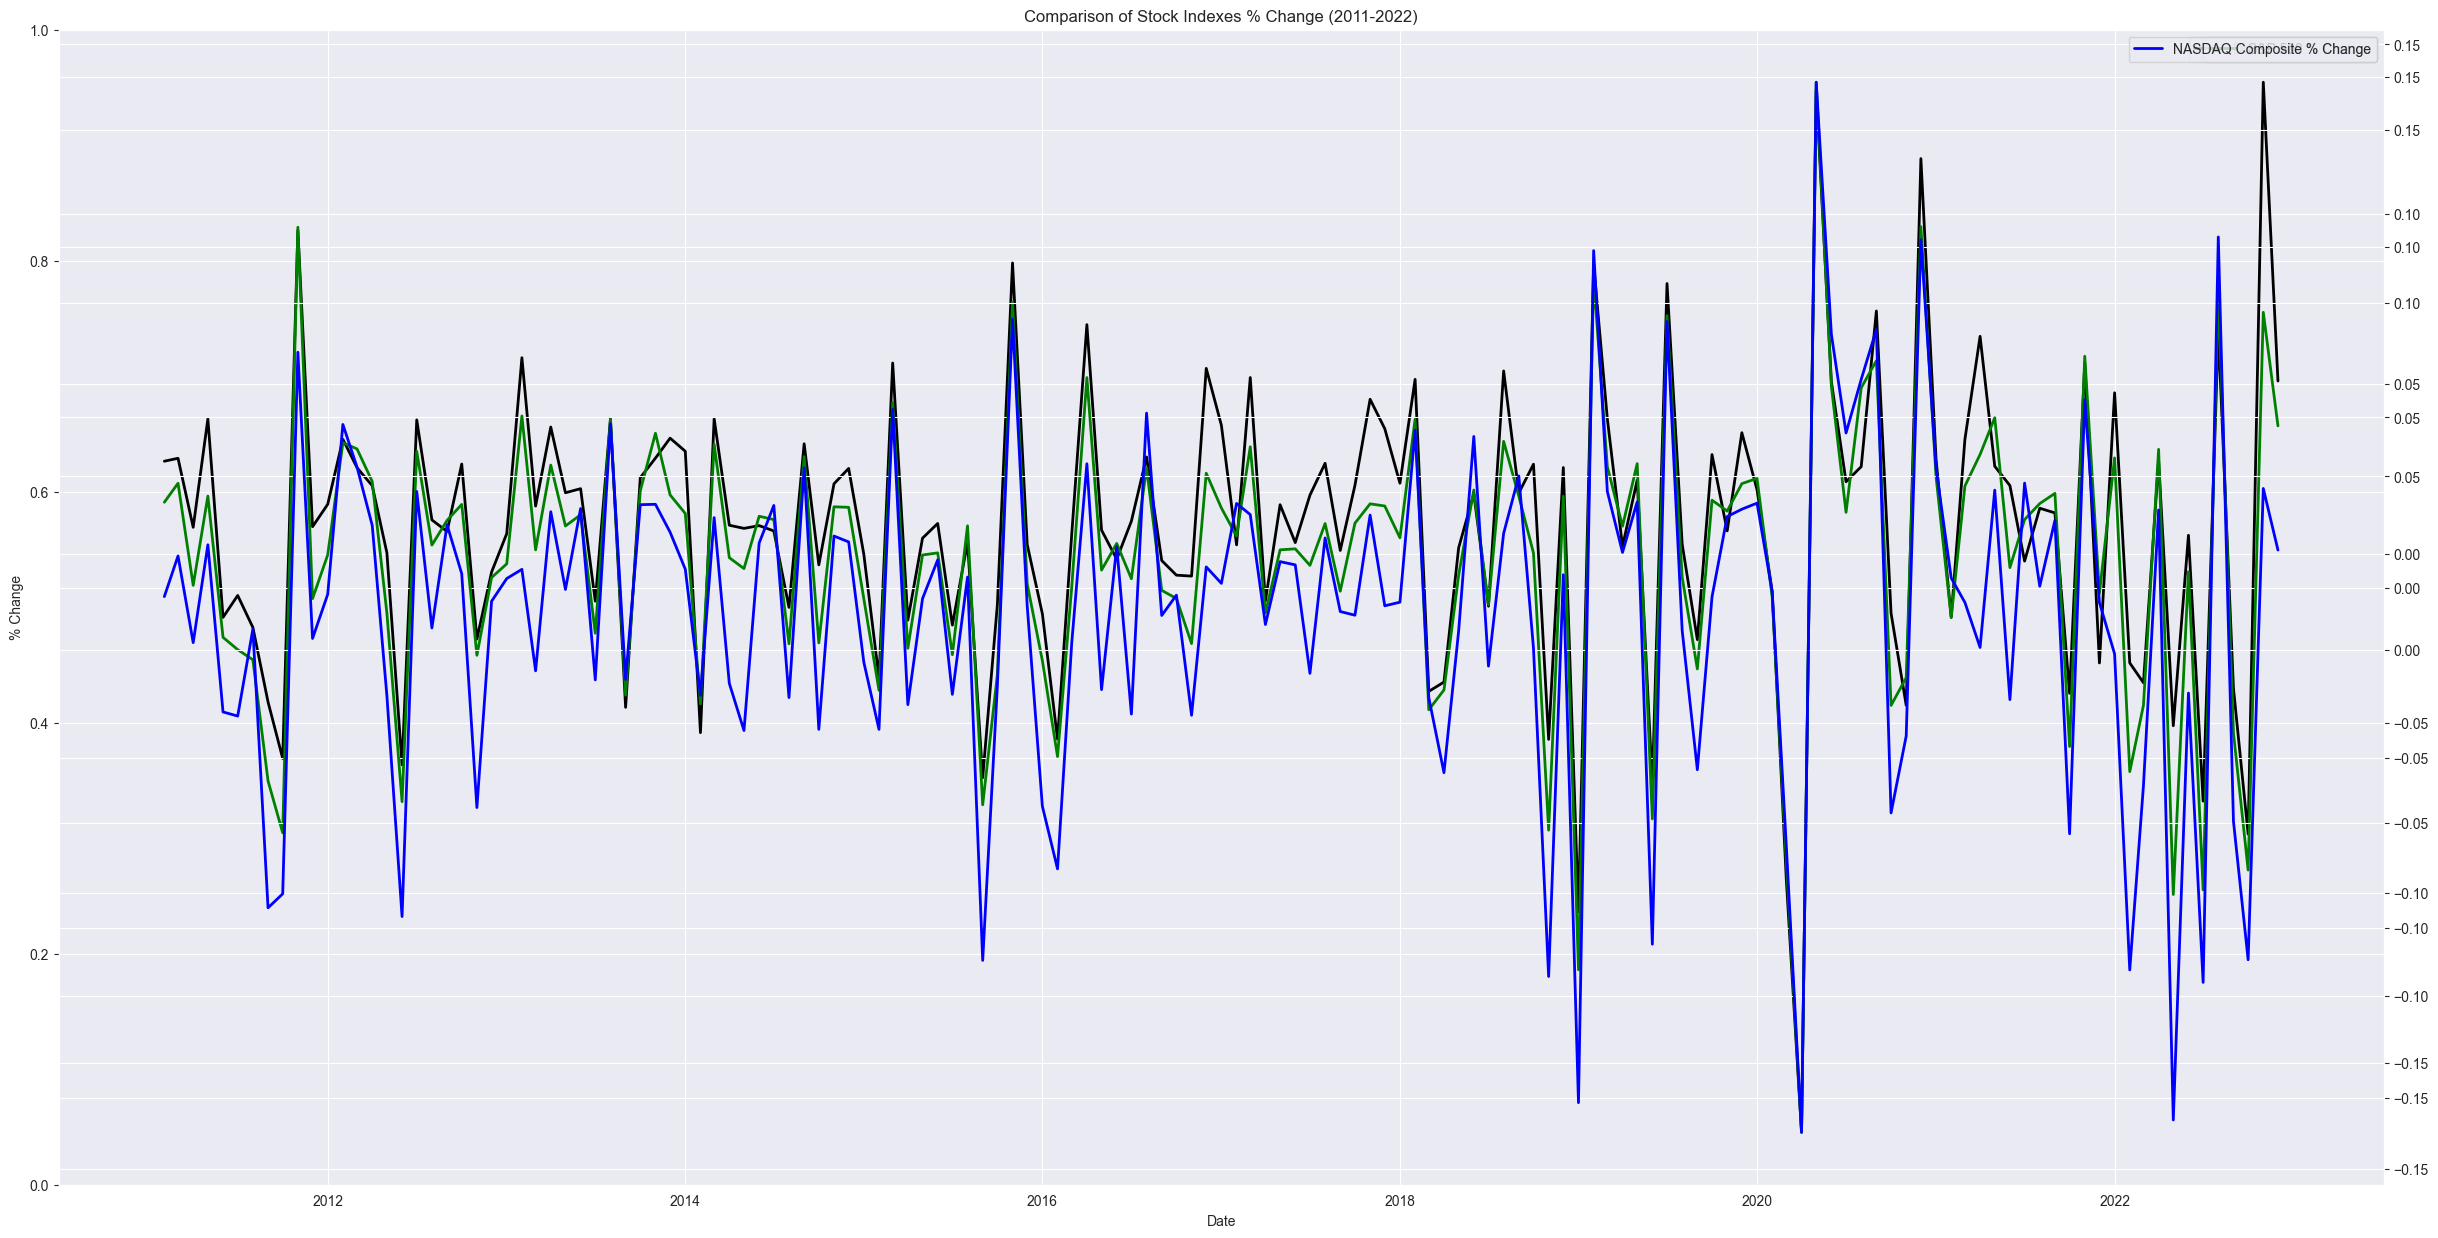

In [40]:
plot_all_stock_rate_change(
    [dow_jones_2011_2022, sp500_2011_2022, nasdaq_2011_2022],
    'Comparison of Stock Indexes % Change (2011-2022)',
    ['Dow Jones % Change', 'S&P 500 % Change', 'NASDAQ Composite % Change'],
    ['black', 'green', 'blue']
)

## Rate Change Comparisons

In [45]:
def plot_rate_changes(sentiment, econ, title, y1_label, y2_label):
    fig, ax1 = plt.subplots(figsize=(30, 15))
    x_label = "Date"

    # Sentiment Analysis

    # dates as x-values (excluding 1st date bc cannot calc rate of change)
    x1 = sentiment['date'][1:]
    score = np.array(sentiment['score'])
    # calculate percent change for y-values
    y1 = (score[1:] - score[:-1]) / score[:-1]

    # Create lineplot with sentiment score percent change vs month
    ax1.plot(x1, y1, color='black', linewidth=2, label=y1_label)

    # # Set labels and titles
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label)

    ax1.legend()

    # Dow Jones Average

    ax2 = ax1.twinx()

    # dates as x-values (excluding 1st date bc cannot calc rate of change)
    x2 = np.array(econ.select('Date').collect()).reshape(-1)[1:]
    # calculate percent change for y-values
    index = np.array(econ.select('Open').collect()).reshape(-1)
    y2 = (index[1:] - index[:-1]) / index[:-1]

    # Create lineplot with sentiment score percent change vs month
    ax2.plot(x2, y2, color='gray', linewidth=2, label=y2_label)

    # # Set labels and titles
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y2_label)
    ax2.set_title(title)

    ax2.legend()

    # Show the plot
    plt.show()

/var/folders/ph/gzj9kkyd6c3155gzpj4kgw840000gn/T/ipykernel_18767/513474490.py:11: RuntimeWarning: divide by zero encountered in divide
  y1 = (score[1:] - score[:-1]) / score[:-1]


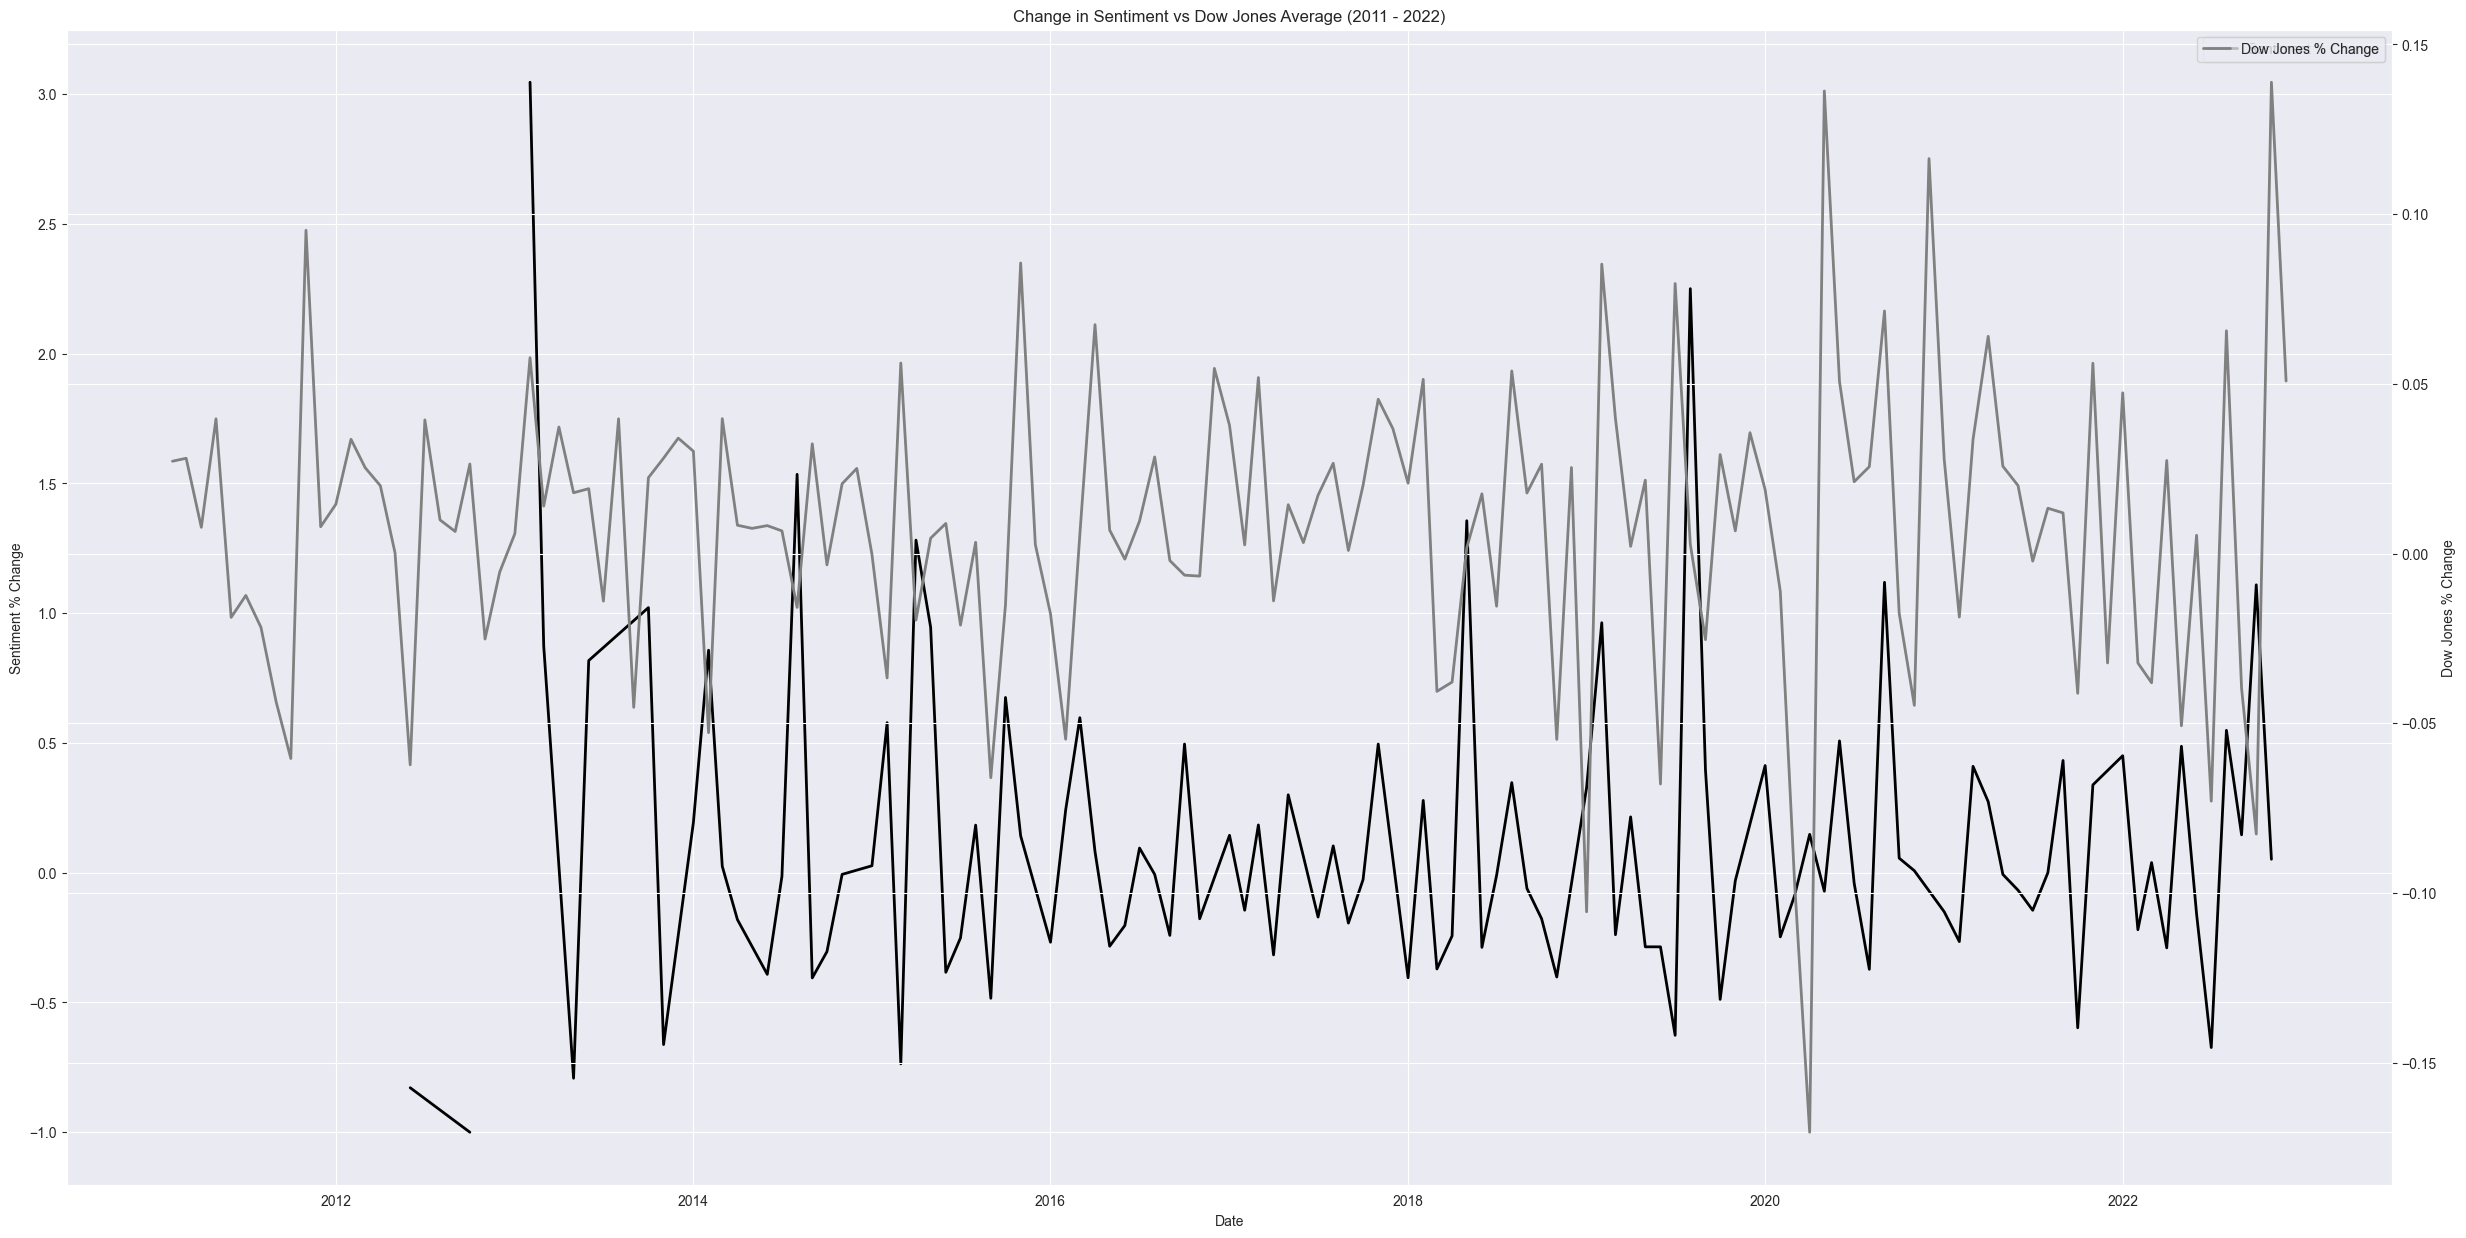

In [46]:
plot_rate_changes(
    pop_sentiment_monthly_percent,
    dow_jones_2011_2022,
    "Change in Sentiment vs Dow Jones Average (2011 - 2022)",
    "Sentiment % Change",
    "Dow Jones % Change")